# German Traffic Sign Kaggle Competition

This notebooks contains my submission to the German Traffic Sign competition, which achieved a test accuracy over 99% 

# Dataloader

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import PIL

# set device to cuda if available, else cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and Dataloaders

In [5]:
class MyDataset(Dataset):
    def __init__(self, X_path="X.pt", y_path="y.pt", transform=None):
        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
        self.transform = transform

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        img = self.X[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.y[idx]

# data paths
X_train_path = "train/X.pt"
y_train_path = "train/y.pt"
X_val_path = "validation/X.pt"
y_val_path = "validation/y.pt"

# parameters
batch_size = 64
momentum = 0.9
lr = 0.01
epochs = 50
log_interval = 100

# transforms (data augmentation)
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=.05, contrast=.05, hue=.05, saturation=.05),
    transforms.RandomApply([
        transforms.RandomAffine(0, translate=(0.2, 0.2)),
        transforms.RandomAffine(0, shear=20),
        transforms.RandomAffine(0, scale=(0.8, 1.2))]),
    transforms.ToTensor()])

train_dataset = MyDataset(X_path=X_train_path, y_path=y_train_path, transform=None)
val_dataset = MyDataset(X_path=X_val_path, y_path=y_val_path)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Viewing Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


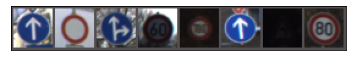

   35    15    36     3     7    35    19     5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


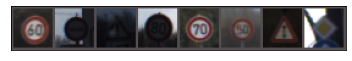

    3     9    18     5     4     2    26    12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


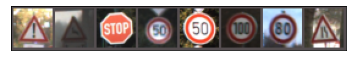

   18    31    14     2     2     7     5    24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


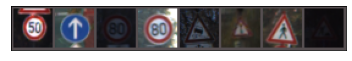

    2    35     5     5    23    26    27    25


In [6]:
# View images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # de-normalizing to see images more clearly
    mean = np.array([0.3337, 0.3064, 0.3171])
    std = np.array([0.2672, 0.2564, 0.2629])
    img = std * img + mean
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def show_images(rows=4, imgs_per_row=8):   
  for i in range(rows):
    # get some random training images
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=imgs_per_row, shuffle=True, num_workers=1)
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    # show images
    imshow(torchvision.utils.make_grid(images))
    # labels
    classes = list(range(43))
    print(' '.join('%5s' % classes[labels[j]] for j in range(imgs_per_row)))

show_images()

# Model

In [7]:
class RossNet(nn.Module):
    def __init__(self):
        super(RossNet, self).__init__()       
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, 3)
        self.conv5_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 3 * 3, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        self.fc2_bn = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2_bn(self.pool(F.relu(self.conv2(x))))
        x = self.conv3_bn(F.relu(self.conv3(x)))
        x = self.conv4_bn(F.relu(self.conv4(x)))
        x = self.conv5_bn(self.pool(F.relu(self.conv5(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Training

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.765594
Train Epoch: 1 [6400/35339 (18%)]	Loss: 0.163383
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.094667
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.039149
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.035190
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.069057

Validation set: Average loss: 0.1010, Accuracy: 3787/3870 (98%)

Train Epoch: 2 [0/35339 (0%)]	Loss: 0.010253
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.008139
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.006052
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.014786
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.002679
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.002765

Validation set: Average loss: 0.0955, Accuracy: 3766/3870 (97%)

Train Epoch: 3 [0/35339 (0%)]	Loss: 0.003083
Train Epoch: 3 [6400/35339 (18%)]	Loss: 0.002883
Train Epoch: 3 [12800/35339 (36%)]	Loss: 0.002011
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.003815
Train Epoch: 3 [25600/35339 (72%)]	Loss: 0.002661
Train Epoch: 3 [32000/35339 (90%)]	L

Text(0, 0.5, 'Accuracy')

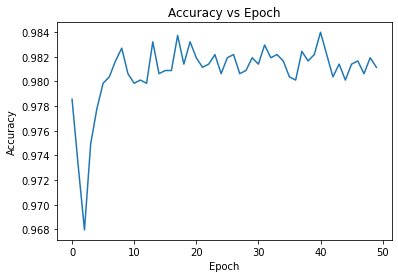

In [10]:
model = RossNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss, torch.true_divide(correct, len(val_loader.dataset))

acc_list = []
for epoch in range(1, epochs + 1):   
    train(epoch)
    val_loss, acc = validation()
    acc_list.append(acc)
    lr_scheduler.step(val_loss)
model_file = 'rossnet.pth'
torch.save(model.state_dict(), model_file)
print('\nSaved model to ' + model_file + '.')
plt.plot(acc_list)
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')